# Calculating hypsometric areas and curves
This notebook goes through the process of calculating hypsometric values for a catchment near the Remarkables Ski Area in New Zealand.

It calculates a standardised curve by scaling elevation and area.  This method allows for the comparison of different catchment areas so that their similarity can be assessed.

In [1]:
import rasterio
import numpy as np
import pandas
import matplotlib.pyplot as plt

The elevation data is a DEM that's been clipped to the catchment boundary.

It's important that the DEM has a projected coordinate system as the cell count and size are used in calculating the areas.

Min elevation: 294
Max elevation: 2227


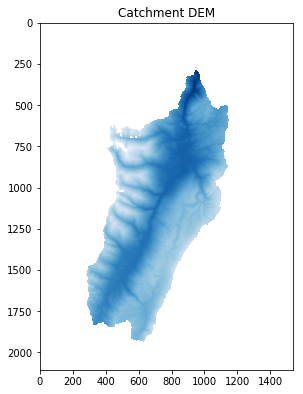

In [2]:
# inputs
elevation = "data/elevation__.tif"

with rasterio.open(elevation) as src:
    array = src.read(1)
    # get the no data value
    nodata = src.nodatavals
    # get the cell size for calculating the area later on
    cellsize = src.res[0]
    
# mask out no data values
marray = np.ma.masked_values(array, nodata)

print(f"Min elevation: {marray.min()}")
print(f"Max elevation: {marray.max()}")

# display the data
plt.subplots(figsize=(10,10))

plt.subplot(121)
plt.imshow(marray, cmap=plt.cm.Blues_r)
plt.title("Catchment DEM")

plt.show()

The elevation array will be set to be zero based so that a proportional elevation can be calculated.  This allows for comparison with other catchments.


In [3]:
def zerobase(maskedarray):
    """
    Set the elevation values so they start from zero
    """
    
    # get min value and take away from dem
    minelev = maskedarray.min()
    maskedarray = maskedarray-minelev

    return maskedarray

zeroedarray = zerobase(marray)

print(f"Min elevation: {zeroedarray.min()}")
print(f"Max elevation: {zeroedarray.max()}")

Min elevation: 0
Max elevation: 1933


Now the elevation data has been prepared, the hypsometric calculations can take place.  The following function is used to do this.

In [4]:
def hypsoarea(array, cellsize, nodata=65535):
    """
    Function to calculate hypsometric areas
    Parameters
    ----------
    array : numpy array
        2D array of the raster image
    cellsize : number
        The cell size
    outputcsv : string
        Path to the csv for output
    Returns
    -------
    df : pandas dataframe
        A dataframe containing the hyposmetric area data
    """
    # mask out no data values
    marray = np.ma.masked_values(array, nodata)

    # get the min and the max
    minelev = marray.min()
    maxelev = marray.max()

    # use to define range and number of slices
    rangeelev = maxelev - minelev
    nslices = rangeelev

    # get the count of each class
    unique, counts = np.unique(marray, return_counts=True)

    totalfreq = 0
    hypsoresults = []

    # calculate hypsometric values
    for elevslice in np.asarray((unique, counts)).T:
        # skip the nodata value
        if elevslice[0] != nodata:
            # proportional elevation
            propelev = elevslice[0] / nslices
            cumfreq = elevslice[1] + totalfreq
            totalfreq = cumfreq
            # proportional area
            area = cumfreq * (cellsize*cellsize)

            slicevalues = {}
            slicevalues['elevation'] = elevslice[0]
            slicevalues['count'] = elevslice[1]
            slicevalues['propelev'] = propelev
            slicevalues['cumfreq'] = cumfreq
            slicevalues['area'] = area
            hypsoresults.append(slicevalues)

    # turn into a dataframe
    df = pandas.DataFrame(hypsoresults)
    
    # caculcate the proportional area
    df['proparea'] = 1 - df['cumfreq'] / totalfreq

    # get top and bottom area values
    areaattop = df['area'][0]
    areaatbottom = df['area'].iloc[-1]

    # calculate left and right areas
    df['leftarea'] = df['area'] - areaattop
    df['rightarea'] = areaatbottom - df['area']

    # first reverse a couple of columns
    # they are used to produce the cumulative right area that needs to be
    # calculated from the bottom upwards
    df['flippedelev'] = df['elevation'].values[::-1]
    df['flippedright'] = df['rightarea'].values[::-1]

    # calculate culm left and right
    df['culmleft'] = 0
    df['culmright'] = 0
    for index, row in df.iterrows():
        if index == 0:
            # first row
            # left
            row.culmleft = df.loc[index, 'culmleft'] = row.leftarea
            prevculmleft = row.culmleft
            prevleft = row.leftarea
            prevelevleft = row.elevation
            # right
            row.culmright = df.loc[index, 'culmright'] = row.flippedright
            prevculmright = row.culmright
            prevright = row.flippedright
            prevelevright = row.flippedelev  
        else:
            # from second row onwards
            # left
            row.culmleft = df.loc[index, 'culmleft'] = prevculmleft + ((row.elevation - prevelevleft) * ((row.leftarea + prevleft) / 2))
            prevculmleft = row.culmleft
            prevleft = row.leftarea
            prevelevleft = row.elevation
            # right
            row.culmright = df.loc[index, 'culmright'] = prevculmright + ((prevelevright - row.flippedelev) * ((row.flippedright + prevright) / 2))
            prevculmright = row.culmright
            prevright = row.flippedright
            prevelevright = row.flippedelev     

    # flip cumulative right
    df['culmright'] = df['culmright'].values[::-1]

    # get the difference between cumulative left and right areas
    df['areadiff'] = df['culmleft'] - df['culmright']

    # drop temporary flipped columns
    df = df.drop(columns=['flippedelev', 'flippedright'])

    return df


Now run the process...

In [5]:
df_hypso = hypsoarea(zeroedarray, cellsize, nodata)

Check the results, making sure the proportional elevation and area values are between 0 and 1.

In [6]:
df_hypso.head()

,area,count,cumfreq,elevation,propelev,proparea,leftarea,rightarea,culmleft,culmright,areadiff
0,54464.874795,73,73,0,0.000000,0.999905,0.000000,5.760630e+08,0.000000,5.297886e+11,-5.297886e+11
1,57449.251496,4,77,1,0.000517,0.999900,2984.376701,5.760601e+08,1492.188351,5.292125e+11,-5.292125e+11
2,61179.722373,5,82,2,0.001035,0.999894,6714.847577,5.760563e+08,6341.800490,5.286365e+11,-5.286365e+11
3,64910.193249,5,87,3,0.001552,0.999887,10445.318454,5.760526e+08,14921.883506,5.280604e+11,-5.280604e+11
4,69386.758301,6,93,4,0.002069,0.999880,14921.883506,5.760481e+08,27605.484485,5.274844e+11,-5.274844e+11


In [7]:
df_hypso.tail()

,area,count,cumfreq,elevation,propelev,proparea,leftarea,rightarea,culmleft,culmright,areadiff
1906,5.761123e+08,2,772171,1925,0.995861,0.000009,5.760578e+08,5222.659227,5.791328e+11,14175.789330,5.791328e+11
1907,5.761138e+08,2,772173,1927,0.996896,0.000006,5.760593e+08,3730.470876,5.802849e+11,5222.659227,5.802849e+11
1908,5.761160e+08,3,772176,1928,0.997413,0.000003,5.760616e+08,1492.188351,5.808609e+11,2611.329613,5.808609e+11
1909,5.761168e+08,1,772177,1929,0.997931,0.000001,5.760623e+08,746.094175,5.814370e+11,1492.188350,5.814370e+11
1910,5.761175e+08,1,772178,1933,1.000000,0.000000,5.760630e+08,0.000000,5.837413e+11,0.000000,5.837413e+11


And plot the curve

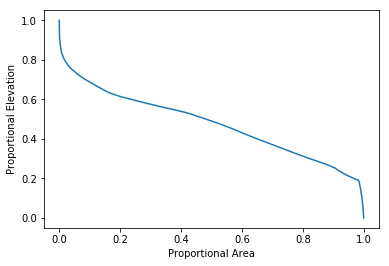

In [8]:
plt.xlabel('Proportional Area')
plt.ylabel('Proportional Elevation')
plt.plot(df_hypso['proparea'], df_hypso['propelev'])

This process can be carried out for a number of catchments so that they can be directly compared.